In [60]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
)
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_dir = '/kaggle/working/wbc_data'
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
os.environ["WANDB_DISABLED"] = "true"
DATA_DIR = dataset_dir
MODEL_NAME = "google/vit-base-patch16-224-in21k"
OUTPUT_DIR = "./wbc_vit_output"

In [4]:
# shutil.rmtree("/kaggle/working/wbc_vit_output")

In [5]:
source_dir = '/kaggle/input/wbc-dataset'
destination_dir = '/kaggle/working/wbc_data'

os.makedirs(destination_dir, exist_ok=True)

## Some Samples

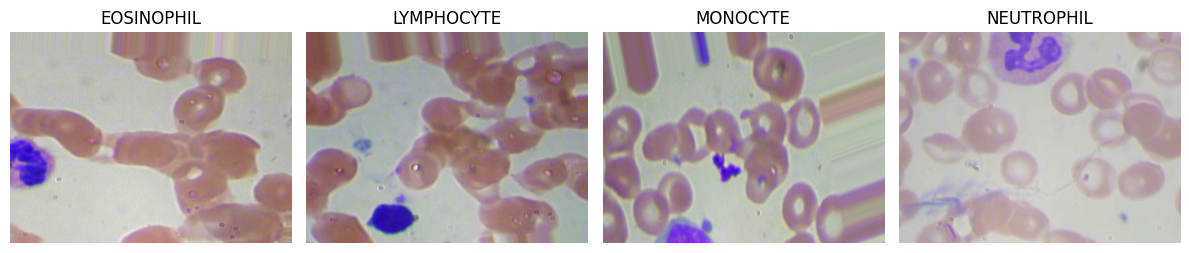

In [6]:
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_dir, class_name)
    sample_image = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, sample_image)
    
    img = Image.open(image_path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Balancing

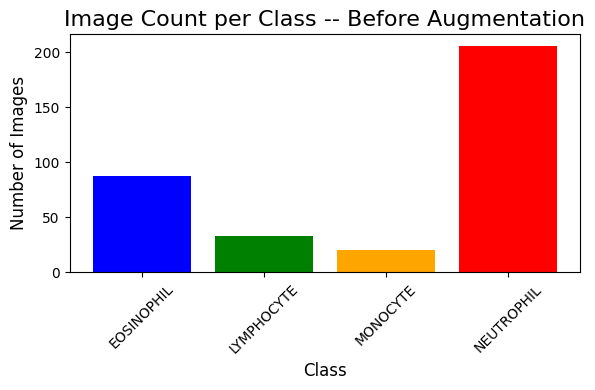

In [7]:
class_counts = {}
for class_name in classes:
    class_path = os.path.join(source_dir, class_name)
    image_count = len(os.listdir(class_path))
    class_counts[class_name] = image_count

plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'green', 'orange', 'red'])
plt.title('Image Count per Class -- Before Augmentation', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [6]:
target_count = 200
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue 
        
    current_images = os.listdir(class_path)
    current_count = len(current_images)
    print(f"Class '{class_name}': {current_count} images found.")
    
    if current_count >= target_count:
        print(f"Class '{class_name}' already has {current_count} images. Skipping augmentation.")
        continue
        
    images_to_generate = target_count - current_count
    print(f"Generating {images_to_generate} images for class '{class_name}'...")
    
    generated_count = 0
    
    while generated_count < images_to_generate:
        image_file = random.choice(current_images)
        img_path = os.path.join(class_path, image_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        
        for batch in datagen.flow(x, batch_size=1, 
                                save_to_dir=class_path,
                                save_prefix="aug",
                                save_format="jpeg"):
            generated_count += 1
            if generated_count >= images_to_generate:
                break
            break
            
    print(f"Class '{class_name}' now has approximately {current_count + generated_count} images.")

print("Augmentation complete for all classes.")

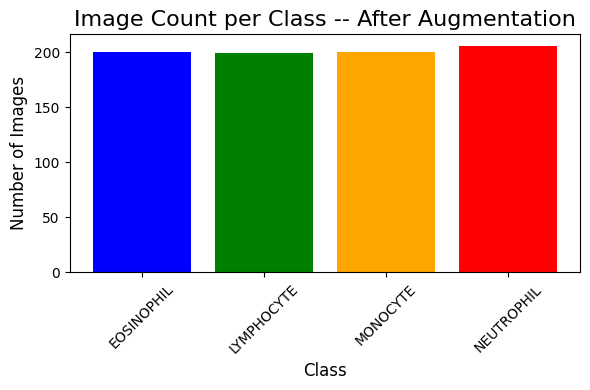

In [7]:
class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    image_count = len(os.listdir(class_path))
    class_counts[class_name] = image_count

plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'green', 'orange', 'red'])
plt.title('Image Count per Class -- After Augmentation', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

## Data Prepairing for Training 

In [8]:
class WBCDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        processed = self.processor(image, return_tensors="pt")
        processed = {k: v.squeeze() for k, v in processed.items()}
        processed['labels'] = self.labels[idx]
        return processed

def load_data(data_dir):
    image_paths = []
    labels = []
    label_to_id = {}
    
    classes = sorted(os.listdir(data_dir))
    for idx, class_name in enumerate(classes):
        label_to_id[class_name] = idx
        class_dir = os.path.join(data_dir, class_name)
        
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(idx)
    
    return image_paths, labels, label_to_id, classes

In [26]:
image_paths, labels, label_to_id, classes = load_data(DATA_DIR)

subset_paths, _, subset_labels, _ = train_test_split(
    image_paths, labels, 
    test_size=0.3,  # Keep only 70% of the data
    stratify=labels,
    random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    subset_paths,
    subset_labels,
    test_size=0.1,
    stratify=subset_labels,
    random_state=42
)

print(f"Total images: {len(image_paths)}")
print(f"Subset size: {len(subset_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")

processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

train_dataset = WBCDataset(train_paths, train_labels, processor)
val_dataset = WBCDataset(val_paths, val_labels, processor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Total images: 805
Subset size: 563
Training images: 506
Validation images: 57


In [10]:
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(classes),
    id2label={i: c for i, c in enumerate(classes)},
    label2id={c: i for i, c in enumerate(classes)}
)

model.classifier = torch.nn.Linear(model.config.hidden_size, 4)
print(model)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [45]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, loss_fn, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.history = {
            "train_loss": [],
            "train_accuracy": [],
            "eval_loss": [],
            "eval_accuracy": []
        }
        self.epochs = 0

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch in tqdm(self.train_loader, desc="Training"):
            images = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            # print(labels)
            self.optimizer.zero_grad()
            
            if isinstance(self.model, ViTForImageClassification):
                outputs = self.model(images).logits
            else:
                outputs = self.model(images)
                
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        loss = running_loss / len(self.train_loader)
        return loss, accuracy
    
    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch in tqdm(self.val_loader, desc="Validation"):
            images = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
    
            
            if isinstance(self.model, ViTForImageClassification):
                outputs = self.model(images).logits
            else:
                outputs = self.model(images)
                
            loss = self.loss_fn(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        loss = running_loss / len(self.val_loader)
        return loss, accuracy

    def fit(self, epochs=20):
        self.epochs = epochs
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_one_epoch()
            self.history["train_loss"].append(train_loss)
            self.history["train_accuracy"].append(train_acc)
            
            val_loss, val_acc = self.evaluate()
            self.history["eval_loss"].append(val_loss)
            self.history["eval_accuracy"].append(val_acc)
            
            print(f"Epoch {epoch+1}/{self.epochs}")
            print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
            print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}\n")

        self.show_results()
        # return self.history
    
    def show_results(self):
        print(f'Train Loss: {self.history["train_loss"][-1]}  |  ', end='')
        print(f'Val Loss: {self.history["eval_loss"][-1]}')
        print(f'Train Accuracy: {self.history["train_accuracy"][-1]}  |  ', end='')
        print(f'Val Accuracy: {self.history["eval_accuracy"][-1]}')

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, self.epochs + 1), self.history["train_loss"], 'b-', label='Train Loss')
        plt.plot(range(1, self.epochs + 1), self.history["eval_loss"], 'r-',label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, self.epochs + 1), self.history["train_accuracy"], 'b-', label='Train Accuracy')
        plt.plot(range(1, self.epochs + 1), self.history["eval_accuracy"], 'r-',label='Validation Accuracy')
        plt.ylim(0, 1)
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def show_trainable_layers(self):
        print("----------------------\nTrainable Layers:")
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(f'\t{name}')
                
    def show_params(self):
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print("----------------------\nTrainable Parameters:")
        print(f'\t{trainable_params}')
        print("Total Parameters:")
        print(f'\t{total_params}')
        

In [46]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

# ViT Model: Google ViT base-patch16-224

## Case 1: Fine-Tuning Classifier

In [54]:
model = ViTForImageClassification.from_pretrained(MODEL_NAME)
model.classifier = torch.nn.Linear(model.config.hidden_size, len(classes))
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

model = freeze(model) 

for param in model.classifier.parameters():
    param.requires_grad = True

model_1 = ModelTrainer(model, train_loader, val_loader, loss_fn, optimizer)
model_1.show_trainable_layers()
model_1.show_params()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------
Trainable Layers:
	classifier.weight
	classifier.bias
----------------------
Trainable Parameters:
	3076
Total Parameters:
	85801732


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


Epoch 1/17
Train Loss: 1.1190884951502085, Train Accuracy: 0.5909090909090909
Validation Loss: 0.960713803768158, Validation Accuracy: 0.6842105263157895



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch 2/17
Train Loss: 0.8173432853072882, Train Accuracy: 0.7351778656126482
Validation Loss: 0.8028348237276077, Validation Accuracy: 0.6666666666666666



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch 3/17
Train Loss: 0.6947844969108701, Train Accuracy: 0.7470355731225297
Validation Loss: 0.7333150058984756, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch 4/17
Train Loss: 0.6240674890577793, Train Accuracy: 0.7628458498023716
Validation Loss: 0.6663583070039749, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Epoch 5/17
Train Loss: 0.5729169445112348, Train Accuracy: 0.7984189723320159
Validation Loss: 0.6363267153501511, Validation Accuracy: 0.7192982456140351



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch 6/17
Train Loss: 0.5340804271399975, Train Accuracy: 0.8043478260869565
Validation Loss: 0.6063436269760132, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch 7/17
Train Loss: 0.5084702116437256, Train Accuracy: 0.8142292490118577
Validation Loss: 0.5788195505738258, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch 8/17
Train Loss: 0.4802013039588928, Train Accuracy: 0.8181818181818182
Validation Loss: 0.5710707530379295, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch 9/17
Train Loss: 0.46151105500757694, Train Accuracy: 0.8537549407114624
Validation Loss: 0.56223314255476, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch 10/17
Train Loss: 0.4426039890386164, Train Accuracy: 0.8596837944664032
Validation Loss: 0.5367981940507889, Validation Accuracy: 0.7543859649122807



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch 11/17
Train Loss: 0.4210992781445384, Train Accuracy: 0.8517786561264822
Validation Loss: 0.5071088373661041, Validation Accuracy: 0.8421052631578947



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch 12/17
Train Loss: 0.40465807961300015, Train Accuracy: 0.8656126482213439
Validation Loss: 0.49886053800582886, Validation Accuracy: 0.8421052631578947



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch 13/17
Train Loss: 0.3931734408251941, Train Accuracy: 0.857707509881423
Validation Loss: 0.5039927288889885, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch 14/17
Train Loss: 0.38157500978559256, Train Accuracy: 0.883399209486166
Validation Loss: 0.48576533049345016, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch 15/17
Train Loss: 0.3744105026125908, Train Accuracy: 0.8774703557312253
Validation Loss: 0.4682411029934883, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


Epoch 16/17
Train Loss: 0.36679824674502015, Train Accuracy: 0.883399209486166
Validation Loss: 0.5128956511616707, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch 17/17
Train Loss: 0.3668036265298724, Train Accuracy: 0.8735177865612648
Validation Loss: 0.4542635679244995, Validation Accuracy: 0.8245614035087719

Train Loss: 0.3668036265298724  |  Val Loss: 0.4542635679244995
Train Accuracy: 0.8735177865612648  |  Val Accuracy: 0.8245614035087719


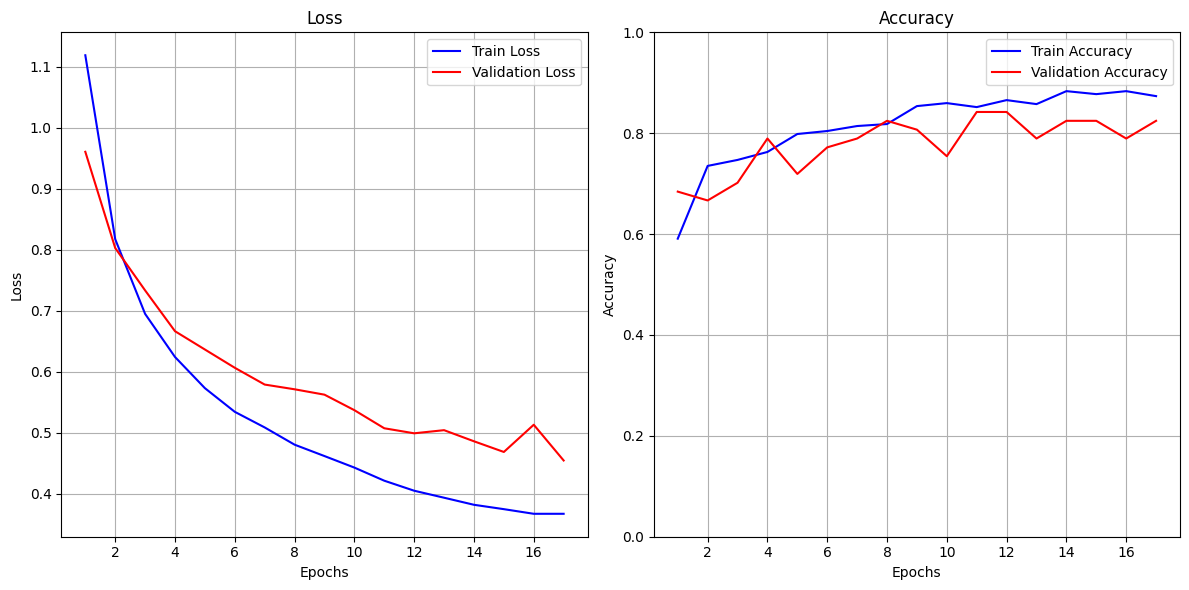

In [55]:
model_1.fit(epochs=17)

## Case 2: Fine-Tuning Classifier and First 2 Layers of the Encoder

In [52]:
model = ViTForImageClassification.from_pretrained(MODEL_NAME)
model.classifier = torch.nn.Linear(model.config.hidden_size, len(classes))
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

model = freeze(model) 

for layer in model.vit.encoder.layer[:2]:
    for param in layer.parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model_2 = ModelTrainer(model, train_loader, val_loader, loss_fn, optimizer)
model_2.show_trainable_layers()
model_2.show_params()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------
Trainable Layers:
	vit.encoder.layer.0.attention.attention.query.weight
	vit.encoder.layer.0.attention.attention.query.bias
	vit.encoder.layer.0.attention.attention.key.weight
	vit.encoder.layer.0.attention.attention.key.bias
	vit.encoder.layer.0.attention.attention.value.weight
	vit.encoder.layer.0.attention.attention.value.bias
	vit.encoder.layer.0.attention.output.dense.weight
	vit.encoder.layer.0.attention.output.dense.bias
	vit.encoder.layer.0.intermediate.dense.weight
	vit.encoder.layer.0.intermediate.dense.bias
	vit.encoder.layer.0.output.dense.weight
	vit.encoder.layer.0.output.dense.bias
	vit.encoder.layer.0.layernorm_before.weight
	vit.encoder.layer.0.layernorm_before.bias
	vit.encoder.layer.0.layernorm_after.weight
	vit.encoder.layer.0.layernorm_after.bias
	vit.encoder.layer.1.attention.attention.query.weight
	vit.encoder.layer.1.attention.attention.query.bias
	vit.encoder.layer.1.attention.attention.key.weight
	vit.encoder.layer.1.attention.attention.

Validation: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch 1/17
Train Loss: 1.1757948528975248, Train Accuracy: 0.5553359683794467
Validation Loss: 0.9669630527496338, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch 2/17
Train Loss: 0.8391941729933023, Train Accuracy: 0.7193675889328063
Validation Loss: 0.8141150325536728, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch 3/17
Train Loss: 0.7068862374871969, Train Accuracy: 0.7549407114624506
Validation Loss: 0.7375300228595734, Validation Accuracy: 0.7192982456140351



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch 4/17
Train Loss: 0.6331501249223948, Train Accuracy: 0.7766798418972332
Validation Loss: 0.6930368840694427, Validation Accuracy: 0.7368421052631579



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch 5/17
Train Loss: 0.5853961855173111, Train Accuracy: 0.7905138339920948
Validation Loss: 0.6548921763896942, Validation Accuracy: 0.7543859649122807



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch 6/17
Train Loss: 0.5432388661429286, Train Accuracy: 0.8043478260869565
Validation Loss: 0.611829474568367, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


Epoch 7/17
Train Loss: 0.5112498765811324, Train Accuracy: 0.8102766798418972
Validation Loss: 0.5902908444404602, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch 8/17
Train Loss: 0.48591166734695435, Train Accuracy: 0.8162055335968379
Validation Loss: 0.5963316857814789, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch 9/17
Train Loss: 0.46364438347518444, Train Accuracy: 0.8320158102766798
Validation Loss: 0.5354174375534058, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch 10/17
Train Loss: 0.4583157114684582, Train Accuracy: 0.8438735177865613
Validation Loss: 0.5356083065271378, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch 11/17
Train Loss: 0.42787433695048094, Train Accuracy: 0.8517786561264822
Validation Loss: 0.5224201008677483, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch 12/17
Train Loss: 0.40878680255264044, Train Accuracy: 0.857707509881423
Validation Loss: 0.5076529607176781, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch 13/17
Train Loss: 0.4009067849256098, Train Accuracy: 0.8596837944664032
Validation Loss: 0.5088883563876152, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


Epoch 14/17
Train Loss: 0.3907419526949525, Train Accuracy: 0.8695652173913043
Validation Loss: 0.49867570400238037, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch 15/17
Train Loss: 0.377181310672313, Train Accuracy: 0.8853754940711462
Validation Loss: 0.4753781035542488, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch 16/17
Train Loss: 0.3652343973517418, Train Accuracy: 0.8675889328063241
Validation Loss: 0.4741743505001068, Validation Accuracy: 0.8421052631578947



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch 17/17
Train Loss: 0.35357538564130664, Train Accuracy: 0.8774703557312253
Validation Loss: 0.4574594646692276, Validation Accuracy: 0.8596491228070176

Train Loss: 0.35357538564130664  |  Val Loss: 0.4574594646692276
Train Accuracy: 0.8774703557312253  |  Val Accuracy: 0.8596491228070176


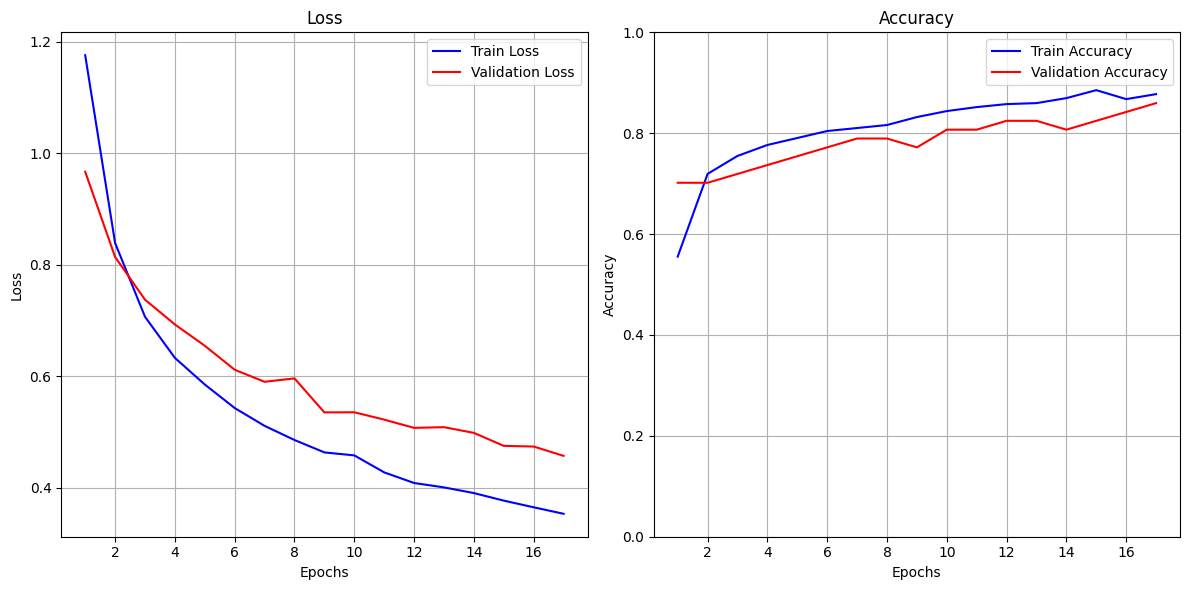

In [53]:
model_2.fit(epochs=17)

## Case 3: Fine-Tuning Classifier and Last 2 Layers of the Encoder

In [56]:
model = ViTForImageClassification.from_pretrained(MODEL_NAME)
model.classifier = torch.nn.Linear(model.config.hidden_size, len(classes))
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

model = freeze(model) 

for layer in model.vit.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model_3 = ModelTrainer(model, train_loader, val_loader, loss_fn, optimizer)
model_3.show_trainable_layers()
model_3.show_params()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------
Trainable Layers:
	vit.encoder.layer.10.attention.attention.query.weight
	vit.encoder.layer.10.attention.attention.query.bias
	vit.encoder.layer.10.attention.attention.key.weight
	vit.encoder.layer.10.attention.attention.key.bias
	vit.encoder.layer.10.attention.attention.value.weight
	vit.encoder.layer.10.attention.attention.value.bias
	vit.encoder.layer.10.attention.output.dense.weight
	vit.encoder.layer.10.attention.output.dense.bias
	vit.encoder.layer.10.intermediate.dense.weight
	vit.encoder.layer.10.intermediate.dense.bias
	vit.encoder.layer.10.output.dense.weight
	vit.encoder.layer.10.output.dense.bias
	vit.encoder.layer.10.layernorm_before.weight
	vit.encoder.layer.10.layernorm_before.bias
	vit.encoder.layer.10.layernorm_after.weight
	vit.encoder.layer.10.layernorm_after.bias
	vit.encoder.layer.11.attention.attention.query.weight
	vit.encoder.layer.11.attention.attention.query.bias
	vit.encoder.layer.11.attention.attention.key.weight
	vit.encoder.layer.11.

Validation: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch 1/17
Train Loss: 1.1587581429630518, Train Accuracy: 0.5849802371541502
Validation Loss: 0.9838031679391861, Validation Accuracy: 0.5964912280701754



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch 2/17
Train Loss: 0.8398072645068169, Train Accuracy: 0.7292490118577075
Validation Loss: 0.8111748248338699, Validation Accuracy: 0.6666666666666666



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch 3/17
Train Loss: 0.706538868136704, Train Accuracy: 0.7470355731225297
Validation Loss: 0.725564032793045, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch 4/17
Train Loss: 0.6302400529384613, Train Accuracy: 0.7766798418972332
Validation Loss: 0.6911922991275787, Validation Accuracy: 0.7192982456140351



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch 5/17
Train Loss: 0.5799198253080249, Train Accuracy: 0.8043478260869565
Validation Loss: 0.651662677526474, Validation Accuracy: 0.6666666666666666



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch 6/17
Train Loss: 0.5423309421166778, Train Accuracy: 0.7964426877470355
Validation Loss: 0.6013397723436356, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch 7/17
Train Loss: 0.5109920231625438, Train Accuracy: 0.8063241106719368
Validation Loss: 0.5902031362056732, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch 8/17
Train Loss: 0.48786336183547974, Train Accuracy: 0.8162055335968379
Validation Loss: 0.5634627416729927, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch 9/17
Train Loss: 0.46581047121435404, Train Accuracy: 0.8359683794466403
Validation Loss: 0.5458100140094757, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch 10/17
Train Loss: 0.4407799234613776, Train Accuracy: 0.8537549407114624
Validation Loss: 0.5194385796785355, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch 11/17
Train Loss: 0.42398875346407294, Train Accuracy: 0.8636363636363636
Validation Loss: 0.5181877240538597, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch 12/17
Train Loss: 0.40968824783340096, Train Accuracy: 0.8636363636363636
Validation Loss: 0.5142390355467796, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch 13/17
Train Loss: 0.3963351617567241, Train Accuracy: 0.8636363636363636
Validation Loss: 0.5063328072428703, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch 14/17
Train Loss: 0.3872869284823537, Train Accuracy: 0.8774703557312253
Validation Loss: 0.4846566393971443, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


Epoch 15/17
Train Loss: 0.3749111257493496, Train Accuracy: 0.8656126482213439
Validation Loss: 0.4765574336051941, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch 16/17
Train Loss: 0.3644848591648042, Train Accuracy: 0.8735177865612648
Validation Loss: 0.46393342316150665, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 17/17
Train Loss: 0.3627264276146889, Train Accuracy: 0.8735177865612648
Validation Loss: 0.4900294840335846, Validation Accuracy: 0.8245614035087719

Train Loss: 0.3627264276146889  |  Val Loss: 0.4900294840335846
Train Accuracy: 0.8735177865612648  |  Val Accuracy: 0.8245614035087719


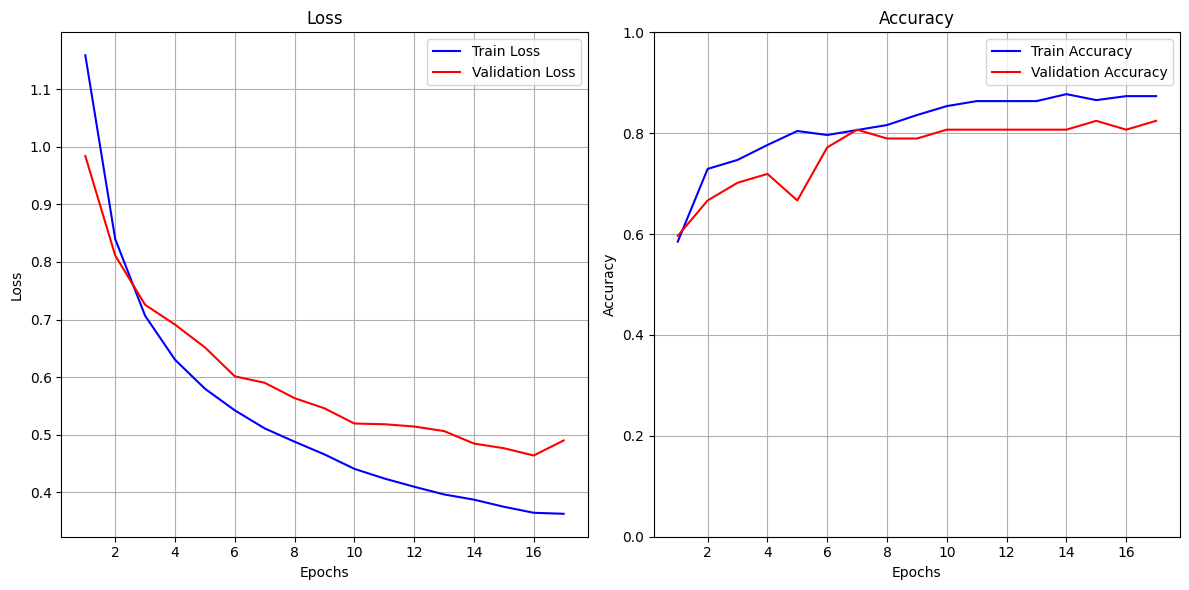

In [57]:
model_3.fit(epochs=17)

## Case 4: Fine-Tuning All Layers

In [58]:
model = ViTForImageClassification.from_pretrained(MODEL_NAME)
model.classifier = torch.nn.Linear(model.config.hidden_size, len(classes))
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

# model = freeze(model) 

model_4 = ModelTrainer(model, train_loader, val_loader, loss_fn, optimizer)
model_4.show_trainable_layers()
model_4.show_params()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------
Trainable Layers:
	vit.embeddings.cls_token
	vit.embeddings.position_embeddings
	vit.embeddings.patch_embeddings.projection.weight
	vit.embeddings.patch_embeddings.projection.bias
	vit.encoder.layer.0.attention.attention.query.weight
	vit.encoder.layer.0.attention.attention.query.bias
	vit.encoder.layer.0.attention.attention.key.weight
	vit.encoder.layer.0.attention.attention.key.bias
	vit.encoder.layer.0.attention.attention.value.weight
	vit.encoder.layer.0.attention.attention.value.bias
	vit.encoder.layer.0.attention.output.dense.weight
	vit.encoder.layer.0.attention.output.dense.bias
	vit.encoder.layer.0.intermediate.dense.weight
	vit.encoder.layer.0.intermediate.dense.bias
	vit.encoder.layer.0.output.dense.weight
	vit.encoder.layer.0.output.dense.bias
	vit.encoder.layer.0.layernorm_before.weight
	vit.encoder.layer.0.layernorm_before.bias
	vit.encoder.layer.0.layernorm_after.weight
	vit.encoder.layer.0.layernorm_after.bias
	vit.encoder.layer.1.attention.attent

Validation: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch 1/17
Train Loss: 1.1313212383538485, Train Accuracy: 0.6126482213438735
Validation Loss: 0.9518781006336212, Validation Accuracy: 0.631578947368421



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch 2/17
Train Loss: 0.8187279105186462, Train Accuracy: 0.7430830039525692
Validation Loss: 0.8008017838001251, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch 3/17
Train Loss: 0.689021147787571, Train Accuracy: 0.7628458498023716
Validation Loss: 0.718035027384758, Validation Accuracy: 0.6666666666666666



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 4/17
Train Loss: 0.6246762461960316, Train Accuracy: 0.7687747035573123
Validation Loss: 0.6649248450994492, Validation Accuracy: 0.7192982456140351



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch 5/17
Train Loss: 0.5804808884859085, Train Accuracy: 0.7865612648221344
Validation Loss: 0.6331006735563278, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch 6/17
Train Loss: 0.5454900162294507, Train Accuracy: 0.8043478260869565
Validation Loss: 0.6133977770805359, Validation Accuracy: 0.7543859649122807



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch 7/17
Train Loss: 0.5111200800165534, Train Accuracy: 0.8102766798418972
Validation Loss: 0.6002475470304489, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch 8/17
Train Loss: 0.4868082022294402, Train Accuracy: 0.8142292490118577
Validation Loss: 0.5702999606728554, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch 9/17
Train Loss: 0.4626159379258752, Train Accuracy: 0.8399209486166008
Validation Loss: 0.5712740868330002, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch 10/17
Train Loss: 0.4449700564146042, Train Accuracy: 0.8300395256916996
Validation Loss: 0.5212364867329597, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch 11/17
Train Loss: 0.4205030482262373, Train Accuracy: 0.857707509881423
Validation Loss: 0.5156124159693718, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


Epoch 12/17
Train Loss: 0.4050156632438302, Train Accuracy: 0.8656126482213439
Validation Loss: 0.4958835244178772, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch 13/17
Train Loss: 0.39391256542876363, Train Accuracy: 0.8616600790513834
Validation Loss: 0.48375987261533737, Validation Accuracy: 0.8070175438596491



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch 14/17
Train Loss: 0.3828489198349416, Train Accuracy: 0.8656126482213439
Validation Loss: 0.499892920255661, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch 15/17
Train Loss: 0.37514768494293094, Train Accuracy: 0.8814229249011858
Validation Loss: 0.49994727224111557, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch 16/17
Train Loss: 0.36600297410041094, Train Accuracy: 0.8774703557312253
Validation Loss: 0.4696441739797592, Validation Accuracy: 0.8245614035087719



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch 17/17
Train Loss: 0.35243388125672936, Train Accuracy: 0.8873517786561265
Validation Loss: 0.4562246575951576, Validation Accuracy: 0.8421052631578947

Train Loss: 0.35243388125672936  |  Val Loss: 0.4562246575951576
Train Accuracy: 0.8873517786561265  |  Val Accuracy: 0.8421052631578947


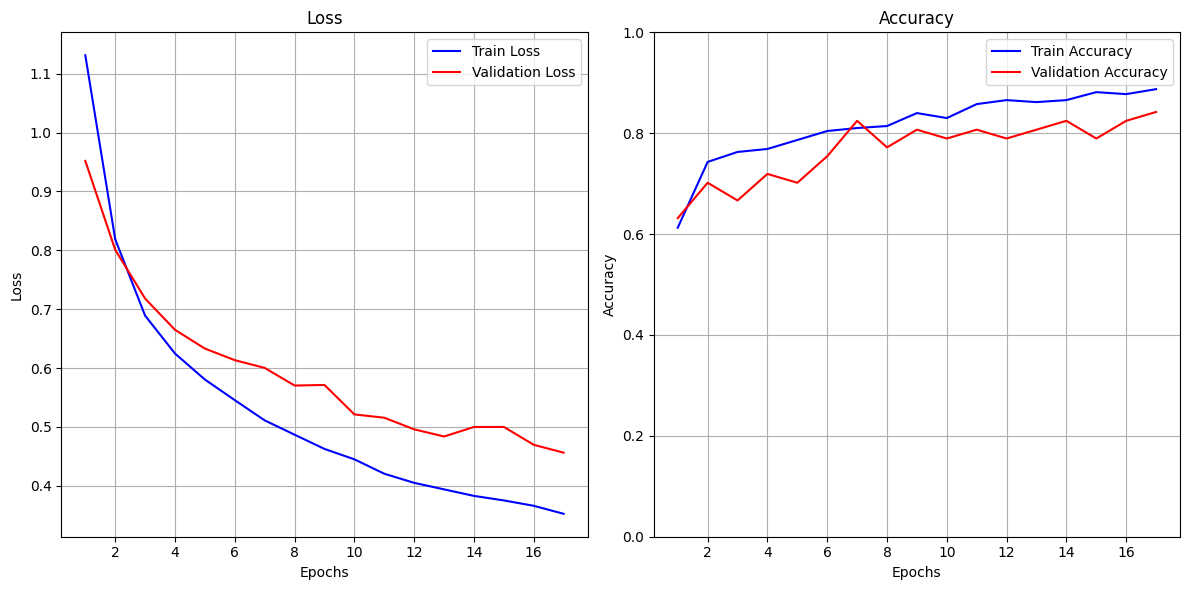

In [59]:
model_4.fit(epochs=17)

# CNN Model: DenseNet-121

## Case 1: Fine-Tuning All Layers

In [66]:
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(classes))
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

# model = freeze(model) 

model_5 = ModelTrainer(model, train_loader, val_loader, loss_fn, optimizer)
model_5.show_trainable_layers()
model_5.show_params()

----------------------
Trainable Layers:
	features.conv0.weight
	features.norm0.weight
	features.norm0.bias
	features.denseblock1.denselayer1.norm1.weight
	features.denseblock1.denselayer1.norm1.bias
	features.denseblock1.denselayer1.conv1.weight
	features.denseblock1.denselayer1.norm2.weight
	features.denseblock1.denselayer1.norm2.bias
	features.denseblock1.denselayer1.conv2.weight
	features.denseblock1.denselayer2.norm1.weight
	features.denseblock1.denselayer2.norm1.bias
	features.denseblock1.denselayer2.conv1.weight
	features.denseblock1.denselayer2.norm2.weight
	features.denseblock1.denselayer2.norm2.bias
	features.denseblock1.denselayer2.conv2.weight
	features.denseblock1.denselayer3.norm1.weight
	features.denseblock1.denselayer3.norm1.bias
	features.denseblock1.denselayer3.conv1.weight
	features.denseblock1.denselayer3.norm2.weight
	features.denseblock1.denselayer3.norm2.bias
	features.denseblock1.denselayer3.conv2.weight
	features.denseblock1.denselayer4.norm1.weight
	features.d

Validation: 100%|██████████| 4/4 [00:00<00:00,  8.85it/s]


Epoch 1/17
Train Loss: 1.1846227925270796, Train Accuracy: 0.466403162055336
Validation Loss: 1.194374293088913, Validation Accuracy: 0.47368421052631576



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.80it/s]


Epoch 2/17
Train Loss: 0.8979298640042543, Train Accuracy: 0.616600790513834
Validation Loss: 0.9855588227510452, Validation Accuracy: 0.543859649122807



Validation: 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


Epoch 3/17
Train Loss: 0.7745608147233725, Train Accuracy: 0.717391304347826
Validation Loss: 0.8711096346378326, Validation Accuracy: 0.631578947368421



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.95it/s]


Epoch 4/17
Train Loss: 0.7392279449850321, Train Accuracy: 0.7154150197628458
Validation Loss: 0.8905770629644394, Validation Accuracy: 0.6842105263157895



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.98it/s]


Epoch 5/17
Train Loss: 0.6065563578158617, Train Accuracy: 0.7984189723320159
Validation Loss: 0.8338508903980255, Validation Accuracy: 0.7192982456140351



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.89it/s]


Epoch 6/17
Train Loss: 0.6388707105070353, Train Accuracy: 0.7509881422924901
Validation Loss: 0.8700640723109245, Validation Accuracy: 0.6842105263157895



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


Epoch 7/17
Train Loss: 0.5722063975408673, Train Accuracy: 0.7944664031620553
Validation Loss: 0.9315444082021713, Validation Accuracy: 0.5964912280701754



Validation: 100%|██████████| 4/4 [00:00<00:00,  9.00it/s]


Epoch 8/17
Train Loss: 0.5894699832424521, Train Accuracy: 0.7549407114624506
Validation Loss: 0.8130198270082474, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  9.00it/s]


Epoch 9/17
Train Loss: 0.5173673508688807, Train Accuracy: 0.8399209486166008
Validation Loss: 0.8142798542976379, Validation Accuracy: 0.6140350877192983



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.84it/s]


Epoch 10/17
Train Loss: 0.543563979677856, Train Accuracy: 0.8023715415019763
Validation Loss: 0.7900794893503189, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.97it/s]


Epoch 11/17
Train Loss: 0.46338478988036513, Train Accuracy: 0.849802371541502
Validation Loss: 0.7379996925592422, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Epoch 12/17
Train Loss: 0.42401109309867024, Train Accuracy: 0.8478260869565217
Validation Loss: 0.7833923622965813, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.56it/s]


Epoch 13/17
Train Loss: 0.4149095914326608, Train Accuracy: 0.8814229249011858
Validation Loss: 0.8585496321320534, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.73it/s]


Epoch 14/17
Train Loss: 0.3756395089440048, Train Accuracy: 0.8715415019762845
Validation Loss: 0.7242573723196983, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


Epoch 15/17
Train Loss: 0.43703440483659506, Train Accuracy: 0.8537549407114624
Validation Loss: 0.833485335111618, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.88it/s]


Epoch 16/17
Train Loss: 0.44097035378217697, Train Accuracy: 0.8438735177865613
Validation Loss: 0.6947683244943619, Validation Accuracy: 0.7543859649122807



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


Epoch 17/17
Train Loss: 0.42983925249427557, Train Accuracy: 0.841897233201581
Validation Loss: 0.7652882486581802, Validation Accuracy: 0.7719298245614035

Train Loss: 0.42983925249427557  |  Val Loss: 0.7652882486581802
Train Accuracy: 0.841897233201581  |  Val Accuracy: 0.7719298245614035


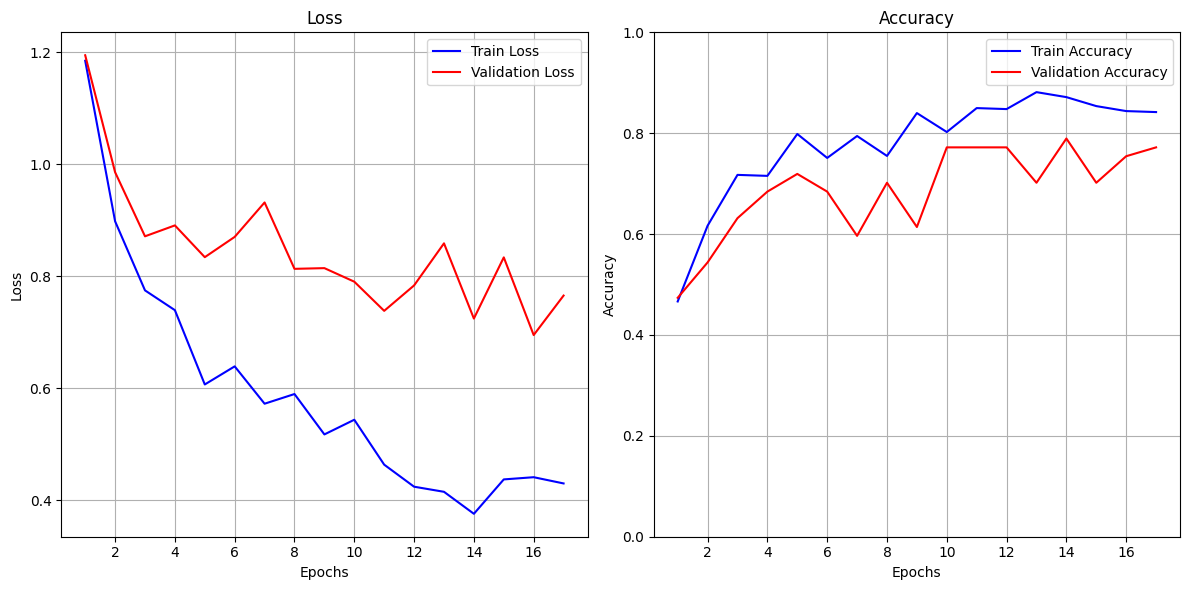

In [67]:
model_5.fit(epochs=17)

## Case 2: Fine-Tuning Classifier

In [68]:
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(classes))
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

model = freeze(model) 

for param in model.classifier.parameters():
    param.requires_grad = True

model_6 = ModelTrainer(model, train_loader, val_loader, loss_fn, optimizer)
model_6.show_trainable_layers()
model_6.show_params()

----------------------
Trainable Layers:
	classifier.weight
	classifier.bias
----------------------
Trainable Parameters:
	4100
Total Parameters:
	6957956


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.97it/s]


Epoch 1/17
Train Loss: 1.261259987950325, Train Accuracy: 0.3952569169960474
Validation Loss: 1.1354484260082245, Validation Accuracy: 0.49122807017543857



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.96it/s]


Epoch 2/17
Train Loss: 0.9610848482698202, Train Accuracy: 0.6106719367588933
Validation Loss: 0.9832647144794464, Validation Accuracy: 0.5263157894736842



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.88it/s]


Epoch 3/17
Train Loss: 0.7821413148194551, Train Accuracy: 0.7035573122529645
Validation Loss: 0.8555102050304413, Validation Accuracy: 0.6140350877192983



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.99it/s]


Epoch 4/17
Train Loss: 0.7397962044924498, Train Accuracy: 0.7015810276679841
Validation Loss: 0.8413939625024796, Validation Accuracy: 0.631578947368421



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


Epoch 5/17
Train Loss: 0.6997159328311682, Train Accuracy: 0.733201581027668
Validation Loss: 0.7871638238430023, Validation Accuracy: 0.6666666666666666



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.57it/s]


Epoch 6/17
Train Loss: 0.6205194527283311, Train Accuracy: 0.7865612648221344
Validation Loss: 0.8123551532626152, Validation Accuracy: 0.631578947368421



Validation: 100%|██████████| 4/4 [00:00<00:00,  9.02it/s]


Epoch 7/17
Train Loss: 0.5901841064915061, Train Accuracy: 0.808300395256917
Validation Loss: 0.8235739469528198, Validation Accuracy: 0.6491228070175439



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.90it/s]


Epoch 8/17
Train Loss: 0.5717085609212518, Train Accuracy: 0.8023715415019763
Validation Loss: 0.7675824016332626, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.68it/s]


Epoch 9/17
Train Loss: 0.49946481082588434, Train Accuracy: 0.8537549407114624
Validation Loss: 0.7220648974180222, Validation Accuracy: 0.7543859649122807



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.97it/s]


Epoch 10/17
Train Loss: 0.45703202299773693, Train Accuracy: 0.857707509881423
Validation Loss: 0.7120247408747673, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.98it/s]


Epoch 11/17
Train Loss: 0.4470542473718524, Train Accuracy: 0.857707509881423
Validation Loss: 0.7857578694820404, Validation Accuracy: 0.7017543859649122



Validation: 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


Epoch 12/17
Train Loss: 0.4701028671115637, Train Accuracy: 0.8399209486166008
Validation Loss: 0.8241169303655624, Validation Accuracy: 0.7368421052631579



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


Epoch 13/17
Train Loss: 0.44413457065820694, Train Accuracy: 0.841897233201581
Validation Loss: 0.7631336748600006, Validation Accuracy: 0.631578947368421



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.96it/s]


Epoch 14/17
Train Loss: 0.4405599981546402, Train Accuracy: 0.8478260869565217
Validation Loss: 0.7439801171422005, Validation Accuracy: 0.7719298245614035



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.90it/s]


Epoch 15/17
Train Loss: 0.37329288572072983, Train Accuracy: 0.883399209486166
Validation Loss: 0.7288314327597618, Validation Accuracy: 0.7894736842105263



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.97it/s]


Epoch 16/17
Train Loss: 0.37711796583607793, Train Accuracy: 0.883399209486166
Validation Loss: 0.6725508272647858, Validation Accuracy: 0.7368421052631579



Validation: 100%|██████████| 4/4 [00:00<00:00,  8.45it/s]


Epoch 17/17
Train Loss: 0.4077351028099656, Train Accuracy: 0.8596837944664032
Validation Loss: 0.7585104256868362, Validation Accuracy: 0.7894736842105263

Train Loss: 0.4077351028099656  |  Val Loss: 0.7585104256868362
Train Accuracy: 0.8596837944664032  |  Val Accuracy: 0.7894736842105263


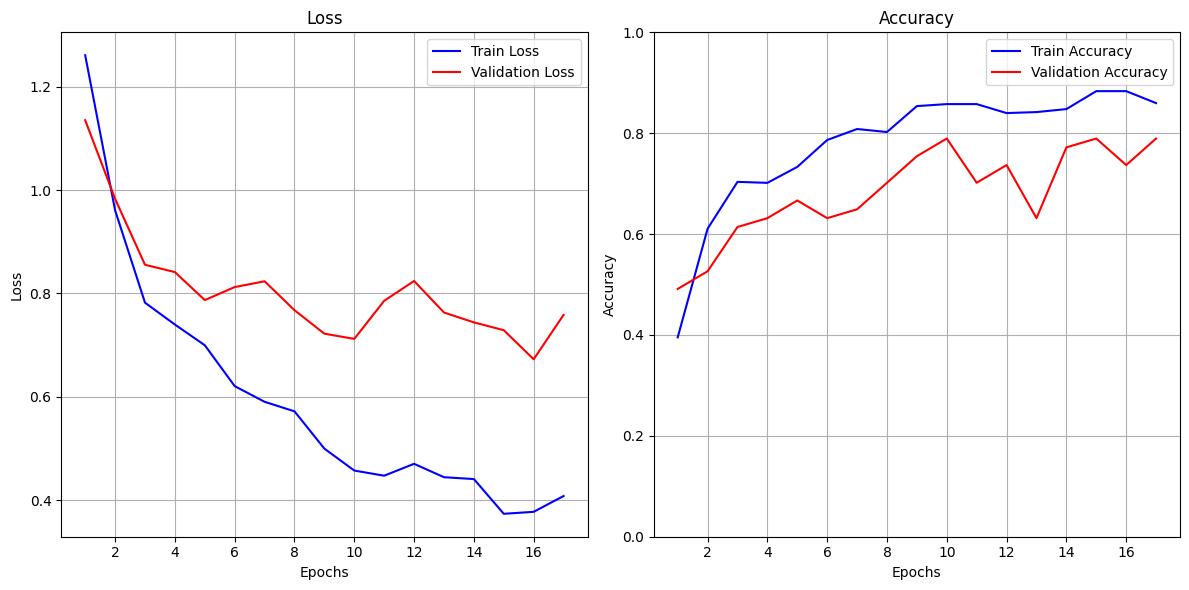

In [69]:
model_6.fit(epochs=17)